In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import fastai
from fastai import *
from fastai.vision import *
from upassai import *
fastai.__version__

'1.0.28'

## Prepare data

In [3]:
vggface2_light_path = '../data/vggface2/vggface2-light'
vggface2_path = '../data/vggface2/vggface2'
max_images_for_identity = 10

In [4]:
faces_valid_df = compile_faces_dataset(vggface2_light_path, pairs=max_images_for_identity, qty=-1)
faces_valid_df.describe()

,source,target,similarity
count,700,700,700
unique,350,387,2
top,valid/n008164/0408_02.jpg,valid/n007166/0104_01.jpg,genuine
freq,2,10,350


In [5]:
faces_train_df = compile_faces_dataset(
    vggface2_light_path, folder='train', qty=-1)
faces_train_df.describe()

,source,target,similarity
count,1200,1200,1200
unique,600,629,2
top,train/n004765/0569_02.jpg,train/n007998/0116_01.jpg,genuine
freq,2,14,600


In [6]:
faces_df = pd.concat([faces_valid_df, faces_train_df])
faces_df.describe()

,source,target,similarity
count,1900,1900,1900
unique,950,1016,2
top,train/n004765/0569_02.jpg,train/n007998/0116_01.jpg,imposter
freq,2,14,950


In [7]:
source_bunch = create_bunch(faces_df, cols='source', path=vggface2_light_path)
target_bunch = create_bunch(faces_df, cols='target', path=vggface2_light_path)

In [8]:
train_ds = TwinDataset(source_bunch.train_ds, target_bunch.train_ds)
valid_ds = TwinDataset(source_bunch.valid_ds, target_bunch.valid_ds)

In [9]:
twin_databunch = DataBunch.create(
    train_ds=train_ds, valid_ds=valid_ds, path=vggface2_light_path, bs=16)

## Train

In [10]:
learner = Learner(twin_databunch,
                  SiameseNetwork(
                      architecture=fastai.vision.models.resnet152,
                      cut=-1,
                      nf=4096, nc=100,
                      lin_ftrs=[800, 500]),
                  loss_func=contrastive_loss, path='./models')
print(learner)

Learner(data=DataBunch;
Train: <upassai.data.TwinDataset object at 0x7fd48500fa58>;
Valid: <upassai.data.TwinDataset object at 0x7fd48500f1d0>;
Test: None, model=SiameseNetwork(
  (body): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256

In [11]:
# freeze resnet
learner.freeze_to(363)

In [12]:
learner.fit_one_cycle(50)

Total time: 24:36
epoch  train_loss  valid_loss
1      20.755341   6.013143    (00:29)
2      19.419386   5.484160    (00:29)
3      18.109903   4.611877    (00:29)
4      16.257189   3.984384    (00:29)
5      13.914362   3.254694    (00:29)
6      11.706858   2.249299    (00:29)
7      9.197072    1.869797    (00:29)
8      6.911445    1.368607    (00:29)
9      4.778595    1.143935    (00:29)
10     3.154103    1.086429    (00:29)
11     1.911915    1.191644    (00:29)
12     1.284775    1.278094    (00:29)
13     1.014309    1.384879    (00:29)
14     0.941556    1.365450    (00:29)
15     0.919699    1.465810    (00:29)
16     0.945193    1.332302    (00:29)
17     0.946711    1.323737    (00:29)
18     0.942585    1.292001    (00:29)
19     0.939334    1.457907    (00:29)
20     0.938748    1.318557    (00:29)
21     0.924754    1.410480    (00:29)
22     0.912181    1.421834    (00:29)
23     0.936777    1.382946    (00:29)
24     0.954216    1.377552    (00:29)
25     0.940869 

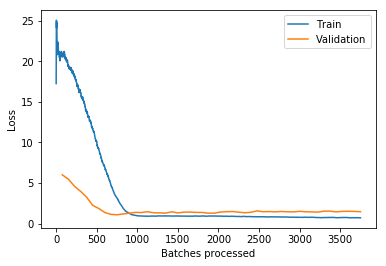

In [13]:
learner.recorder.plot_losses()

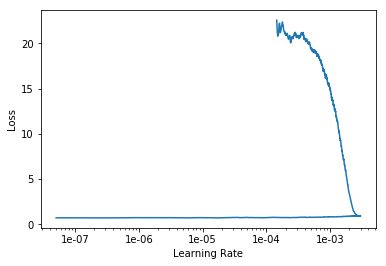

In [14]:
learner.recorder.plot()

In [15]:
learner.save('resnet152-frozen-after50')

In [18]:
import torchvision

In [24]:
learner = Learner(twin_databunch,
                  SiameseNetwork(
                      architecture=torchvision.models.densenet121,
                      cut=-1,
                      nf=2048, nc=100,
                      lin_ftrs=[800, 500]),
                  loss_func=contrastive_loss, path='./models')
print(learner)

/opt/conda/envs/upass/lib/python3.6/site-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


Learner(data=DataBunch;
Train: <upassai.data.TwinDataset object at 0x7fd48500fa58>;
Valid: <upassai.data.TwinDataset object at 0x7fd48500f1d0>;
Test: None, model=SiameseNetwork(
  (body): Sequential(
    (0): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), s

In [25]:
learner.freeze_to(365)

In [26]:
learner.fit_one_cycle(50)

Total time: 13:50
epoch  train_loss  valid_loss
1      22.102684   6.222566    (00:16)
2      21.049049   5.721311    (00:16)
3      19.838438   5.139969    (00:16)
4      17.046839   4.353745    (00:16)
5      14.643032   3.568852    (00:16)
6      12.441276   2.892341    (00:16)
7      9.973630    2.039109    (00:16)
8      7.401451    1.473577    (00:16)
9      5.295670    1.164889    (00:16)
10     3.505704    1.022961    (00:16)
11     2.102705    1.053233    (00:16)
12     1.332535    1.196132    (00:16)
13     1.043897    1.255865    (00:16)
14     0.953136    1.328448    (00:16)
15     0.931015    1.305786    (00:16)
16     0.934405    1.336072    (00:16)
17     0.927020    1.398350    (00:16)
18     0.926161    1.346012    (00:16)
19     0.920251    1.388949    (00:16)
20     0.936859    1.366080    (00:16)
21     0.923364    1.338846    (00:16)
22     0.906078    1.301874    (00:16)
23     0.920810    1.412385    (00:16)
24     0.913181    1.405631    (00:16)
25     0.887317 

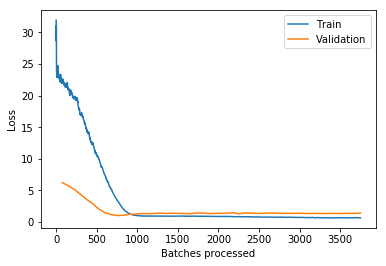

In [27]:
learner.recorder.plot_losses()

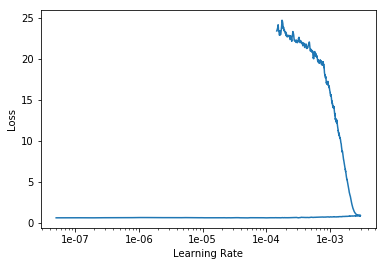

In [28]:
learner.recorder.plot()

In [29]:
learner.save('densenet121-frozen-after50')